In [2]:
# import packages

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# create folder to store best parameters
best_param_folder = '/home/erussek/projects/RNNs/best_hyper_params_sequential'
if not os.path.exists(best_param_folder):
    os.mkdir(best_param_folder)

# functions to generate loss curves for setting and get best parameters
def load_results(run_idx, part_name,train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers):
    
    if part_name == 'Human_Only':
        to_save_folder = '/scratch/gpfs/erussek/RNN_project/Hyper_Param_Search_Sequential_F'
    else:
        to_save_folder = '/scratch/gpfs/erussek/RNN_project/Hyper_Param_Search_Sequential_F'

    res_name_full = '{}_{}_{}_run_{}_model_name_{}_d_model_{}_sim_lr_{}_human_lr_{}_n_head_{}_n_layers_{}'.format(part_name,train_seq_part, fu, run_idx, model_name, d_model, sim_lr, human_lr, n_head, n_layers)
    param_dict = {'part_name': part_name, 'train_seq_part': train_seq_part, 'fu': fu, 'model_name':model_name, 'd_model':d_model, 'sim_lr':sim_lr, 'human_lr':human_lr, 'n_head':n_head, 'n_layers':n_layers}
    res_file_name = res_name_full + '.pickle'
    res_full_file_name = os.path.join(to_save_folder, res_file_name)
    file = open(res_full_file_name, 'rb')
    res = pickle.load(file)
    return res, param_dict

def load_results_all_runs(part_name,train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = 2):
    
    results_list = []
    
    for run_idx in range(n_runs):
        res, param_dict = load_results(run_idx, part_name,train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers)
        results_list.append(res)
        
    return results_list, param_dict

def get_learning_curve(part_name,train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = 1, smooth_loss = True, which_loss = 'simulation_loss_results'): 
    
    results_list, param_dict = load_results_all_runs(part_name,train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = n_runs)
    
    loss_results_by_run = np.array([res[which_loss] for res in results_list])
    
    mn_loss = np.mean(loss_results_by_run, axis=0)
    
    if smooth_loss:
        mn_loss = gaussian_filter(mn_loss, 3)
    
    return mn_loss, np.std(loss_results_by_run, axis=0)/np.sqrt(n_runs), results_list[0]['train_sequence_number'], results_list[0]['simulation_sequence_number'], results_list[0]['human_sequence_number'], param_dict

def get_best_params(res_losses, res_params, simulation_sequence_number, human_sequence_number):
    loss_arr = np.array(res_losses)
    
    min_val = np.min(loss_arr)
    
    min_flat_idx = np.argmin(loss_arr)
    (min_train_setting_idx,min_train_num_idx) = divmod(min_flat_idx, loss_arr.shape[1])

    best_params = res_params[min_train_setting_idx]
    
    best_params['best_sim_num'] = simulation_sequence_number[min_train_setting_idx][min_train_num_idx]
    best_params['best_hum_num'] = human_sequence_number[min_train_setting_idx][min_train_num_idx]

    best_params['min_loss'] = min_val
    
    return best_params



In [3]:
## These are the varieties of model types, training data types, and training input representation types that we want to find the best params for
model_names = ['LSTM','GRU','Transformer']
train_seq_parts = ['fix_only', 'fix_and_choice']
fix_unit_types = ['ID', 'all']

# These are the hyper-parameters that we want to vary / find the best of
hidden_sizes = np.array([8, 16, 32, 64, 128, 256, 512])
sim_lrs = np.array([1e-4, 1e-3])
human_lrs_train = np.array([1e-4, 1e-3])
human_lrs_finetune = np.array([1e-5, 1e-4, 1e-3])

# For the transformer only
transformer_attention_heads = [4]
transformer_layers = [2]


n_runs = 5



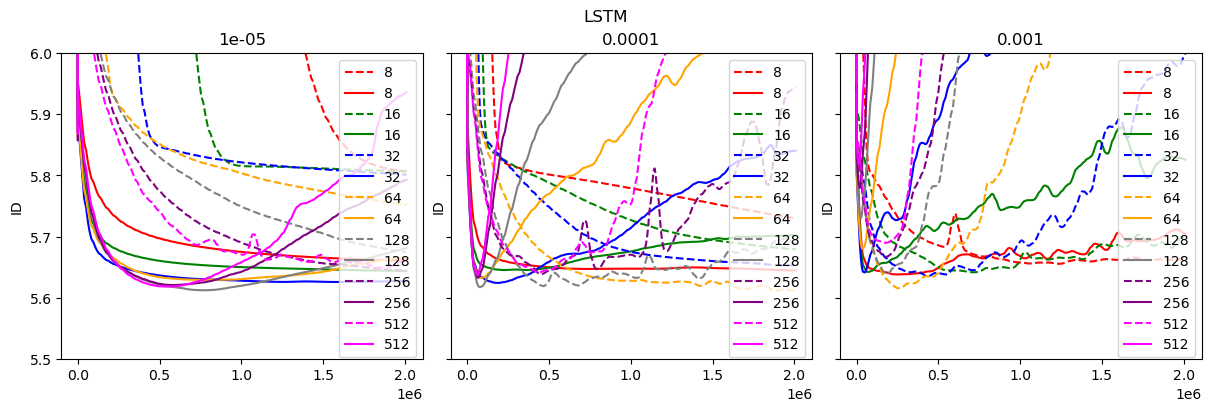

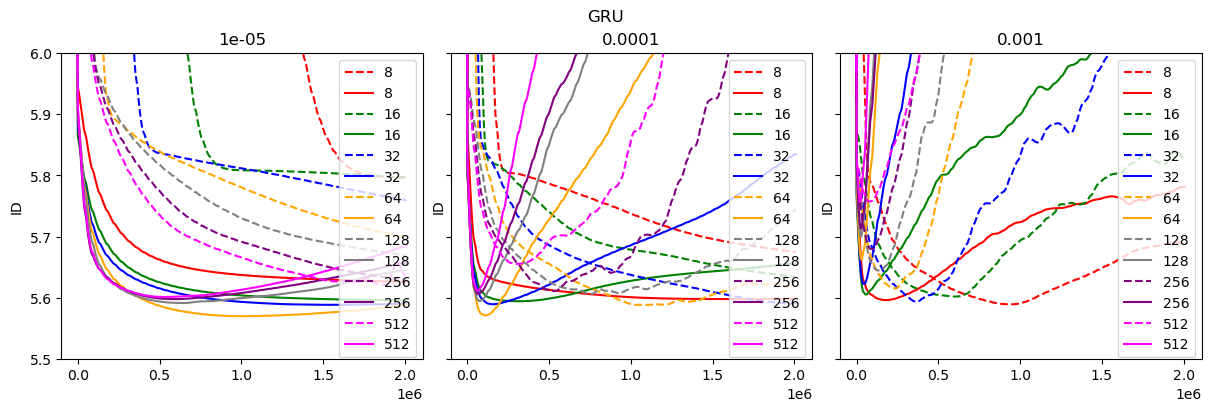

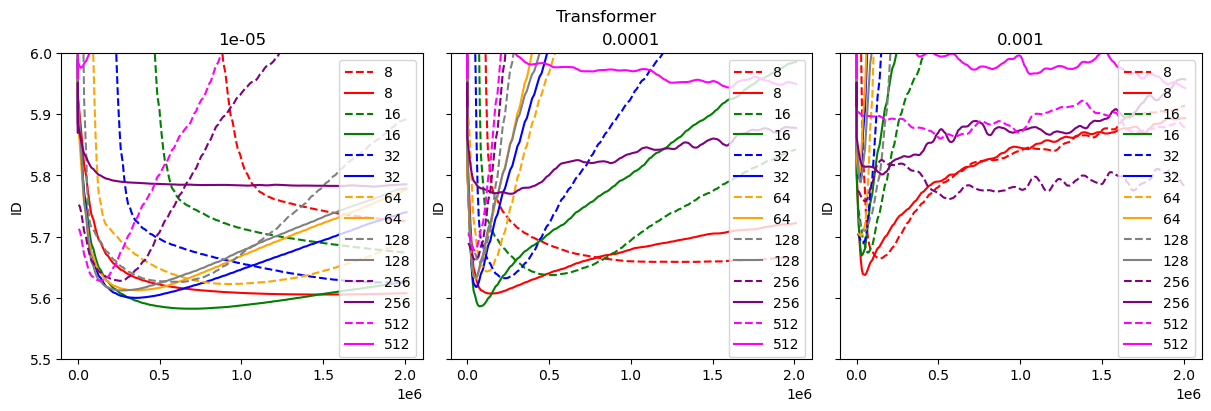

In [5]:
fix_unit_types = ['ID']


part_names = ["Simulated_Only", "Human_Only", "Simulated_and_Human"]

train_seq_part = 'fix_and_choice'

human_lrs_finetune = np.array([1e-5, 1e-4, 1e-3])

colors = ['r', 'g', 'b', 'orange', 'gray', 'purple', 'magenta']

for model_idx, model_name in enumerate(model_names):
    
    fig,ax = plt.subplots(1, 3, figsize = (12,4), dpi = 100, sharex = True, sharey = True, constrained_layout = True)

    for human_lr_idx, human_lr in enumerate(human_lrs_finetune):
        for d_idx, d_model in enumerate(hidden_sizes):
            
            for fu_idx, fu in enumerate(fix_unit_types):
            
                # fu = 'all'
                sim_lr = 0

                if model_name == 'Transformer':
                    n_head = 4
                    n_layers = 2
                else:
                    n_head = 0
                    n_layers = 0
                sim_lr = 0

                mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, param_dict = get_learning_curve(part_names[1],train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = n_runs, which_loss = 'human_loss_results')
                ax[human_lr_idx].plot(human_sequence_number, mean_loss, label = d_model, c = colors[d_idx], ls = '--')

                sim_lr = .001

                mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, param_dict = get_learning_curve(part_names[2],train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = n_runs, which_loss = 'human_loss_results')

                ax[human_lr_idx].plot(human_sequence_number, mean_loss, label = d_model, ls = '-', c = colors[d_idx])

                ax[human_lr_idx].legend()
                
                ax[human_lr_idx].set_title(human_lr)
                
                ax[human_lr_idx].set_ylabel(fu)
        fig.suptitle(model_name)

                
            
    ax[0].set_ylim(5.5,6)


In [6]:
%run ID_Best_Hyperparams_Sequential.py

## Make folder to save best params
best_param_folder = '/home/erussek/projects/RNNs/best_hyper_params_sequential'

# Read in best hyper params...
best_param_dict = pickle.load(open(os.path.join(best_param_folder, 'best_hyper_params.pkl'), 'rb'))

best_param_dict

{'fix_and_choice_Human_Only_LSTM_ID': {'part_name': 'Human_Only',
  'train_seq_part': 'fix_and_choice',
  'fu': 'ID',
  'model_name': 'LSTM',
  'd_model': 64,
  'sim_lr': 0,
  'human_lr': 0.0001,
  'n_head': 0,
  'n_layers': 0,
  'best_sim_num': 0,
  'best_hum_num': 2009600,
  'min_loss': 5.611511983578005},
 'fix_and_choice_Human_Only_GRU_ID': {'part_name': 'Human_Only',
  'train_seq_part': 'fix_and_choice',
  'fu': 'ID',
  'model_name': 'GRU',
  'd_model': 64,
  'sim_lr': 0,
  'human_lr': 0.0001,
  'n_head': 0,
  'n_layers': 0,
  'best_sim_num': 0,
  'best_hum_num': 1100800,
  'min_loss': 5.588549829166084},
 'fix_and_choice_Human_Only_Transformer_ID': {'part_name': 'Human_Only',
  'train_seq_part': 'fix_and_choice',
  'fu': 'ID',
  'model_name': 'Transformer',
  'd_model': 64,
  'sim_lr': 0,
  'human_lr': 1e-05,
  'n_head': 4,
  'n_layers': 2,
  'best_sim_num': 0,
  'best_hum_num': 915200,
  'min_loss': 5.622669617034328},
 'fix_and_choice_Simulated_and_Human_LSTM_ID': {'part_name':

Simulated_and_Human_LSTM_5.730024329673437
Simulated_and_Human_LSTM_5.679277871150806
Simulated_and_Human_LSTM_5.652725021166992
Simulated_and_Human_LSTM_5.6110981483185896
Simulated_and_Human_LSTM_5.617151717361612
Simulated_and_Human_LSTM_5.6376643531742
Simulated_and_Human_LSTM_5.6389803667023175
Human_Only_LSTM_5.660686553637142
Human_Only_LSTM_5.643997195198796
Human_Only_LSTM_5.625951148000163
Human_Only_LSTM_5.629353652907637
Human_Only_LSTM_5.612320280718454
Human_Only_LSTM_5.6209051888693615
Human_Only_LSTM_5.618452053660764
Simulated_and_Human_GRU_5.675103162500648
Simulated_and_Human_GRU_5.634315764528444
Simulated_and_Human_GRU_5.590173574037259
Simulated_and_Human_GRU_5.588003623776999
Simulated_and_Human_GRU_5.605345978562188
Simulated_and_Human_GRU_5.610008582787549
Simulated_and_Human_GRU_5.655255169281908
Human_Only_GRU_5.626301225071089
Human_Only_GRU_5.595717121377867
Human_Only_GRU_5.588669017280467
Human_Only_GRU_5.570072964778001
Human_Only_GRU_5.591415516410292
H

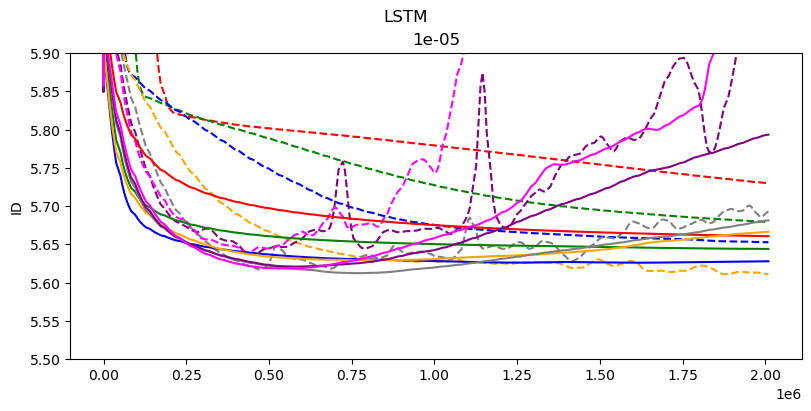

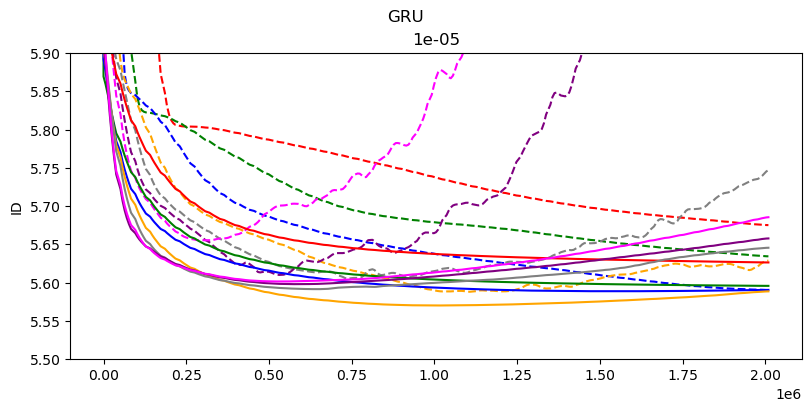

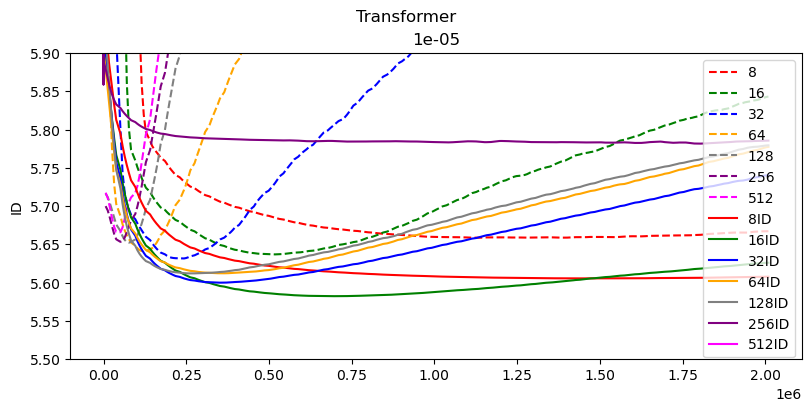

In [44]:
fix_unit_types = ['ID']


part_names = ["Simulated_Only", "Human_Only", "Simulated_and_Human"]

train_seq_part = 'fix_and_choice'

human_lrs_finetune = np.array([1e-5])

human_lrs_train = np.array([1e-4])
hidden_sizes = np.array([8, 16, 32, 64, 128, 256, 512])

colors = ['r', 'g', 'b', 'orange', 'gray', 'purple', 'magenta']

for model_idx, model_name in enumerate(model_names):
    
    fig,ax = plt.subplots(1, figsize = (8,4), dpi = 100, sharex = True, sharey = True, constrained_layout = True)

    for human_lr_idx, human_lr in enumerate(human_lrs_train):
        for d_idx, d_model in enumerate(hidden_sizes):
            
            for fu_idx, fu in enumerate(fix_unit_types):
            
                # fu = 'all'
                sim_lr = 0

                if model_name == 'Transformer':
                    n_head = 4
                    n_layers = 2
                else:
                    n_head = 0
                    n_layers = 0
                sim_lr = 0


                sim_lr = 0

                mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, param_dict = get_learning_curve(part_names[1],train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = n_runs, which_loss = 'human_loss_results')
                
                print('{}_{}_{}'.format(part_names[2], model_name, np.min(mean_loss)))

                ax.plot(human_sequence_number, mean_loss, label = d_model, ls = '--', c = colors[d_idx])

                
                ax.set_title(human_lr)
                
                ax.set_ylabel(fu)
                
                
    for human_lr_idx, human_lr in enumerate(human_lrs_finetune):
        for d_idx, d_model in enumerate(hidden_sizes):
            
            for fu_idx, fu in enumerate(fix_unit_types):
            
                # fu = 'all'
                sim_lr = .001

                if model_name == 'Transformer':
                    n_head = 4
                    n_layers = 2
                else:
                    n_head = 0
                    n_layers = 0

                mean_loss, sem_loss, train_sequence_number,simulation_sequence_number, human_sequence_number, param_dict = get_learning_curve(part_names[2],train_seq_part, fu, model_name, d_model, sim_lr, human_lr, n_head, n_layers, n_runs = n_runs, which_loss = 'human_loss_results')
                ax.plot(human_sequence_number, mean_loss, label = str(d_model) + 'ID', c = colors[d_idx])
                
                print('{}_{}_{}'.format(part_names[1], model_name, np.min(mean_loss)))

                #sim_lr = .001

                
                ax.set_title(human_lr)
                
                ax.set_ylabel(fu)
        fig.suptitle(model_name)

        fig.suptitle(model_name)

                
            
    ax.set_ylim(5.5,5.9)
ax.legend()
